In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
import glob
# from ggplot import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def days_hours_minutes(td):
    mydict = {}
    mydict['days'] = td.days
    mydict['hours'] = td.seconds//3600
    mydict['minutes'] = (td.seconds//60)%60
    return mydict

In [7]:
# Get all tweets in directory
# get all filenames

# We know all csv files end in 2016
bridge_files = glob.glob("*2016.csv")

In [59]:
frame = pd.DataFrame()
list_ = []
for f in bridge_files:
    df = pd.read_csv(f)
    list_.append(pd.read_csv(f))
df = frame.append(list_)

In [60]:
len(df)

12891

In [61]:
# Load tweet data
# df = pd.read_csv('SDOTBridges_tweets.csv')
# df = pd.read_csv('SDOTBridges_tweets_latest.csv')

In [62]:
df

,id,created_at,text
0,693601965163442176,2016-01-31 01:09:29,The Fremont Bridge has reopened to traffic - ...
1,693599354439933952,2016-01-31 00:59:07,The Fremont Bridge has closed to traffic - 4...
2,693590335797092352,2016-01-31 00:23:16,The Montlake Bridge has reopened to traffic ...
3,693588978541309952,2016-01-31 00:17:53,The Montlake Bridge has closed to traffic - ...
4,693588472922177536,2016-01-31 00:15:52,The University Bridge has reopened to traffi...
5,693586910921396224,2016-01-31 00:09:40,The University Bridge has closed to traffic ...
6,693586087021654016,2016-01-31 00:06:24,The Ballard Bridge has reopened to traffic - ...
7,693585592035094530,2016-01-31 00:04:25,The Ballard Bridge has closed to traffic - 4...
8,693583345800736768,2016-01-30 23:55:30,The Fremont Bridge has reopened to traffic - ...
9,693580696598630400,2016-01-30 23:44:58,The Fremont Bridge has closed to traffic - 3...


In [63]:
# Extract data from CSV by splitting text columns
df['bridge'] = df['text'].map(lambda x: x.split('The ')[-1].split(' Bridge')[0])
df['time'] = df['text'].map(lambda x: x.split('- ')[-1])
df['event'] = df['text'].apply(lambda x: 'closed' if ('closed' in x) else 'open')
df['date'] = df['created_at'].map(lambda x: x.split(' ')[0])
df_clean = df[['bridge','time','event', 'date', 'text']]

In [64]:
# Now we have all the relevant open and closing information
# we need to reorganize  to turn open and close events into periods of closure

In [65]:
# Some of the fields include errors we need to remove
df_clean.groupby('bridge').count()

,time,event,date,text
bridge,,,,
1st Ave S,1321,1321,1321,1321
1st Ave S bridge has closed to traffic,1,1,1,1
Ballard,3299,3299,3299,3299
Fremont,2624,2624,2624,2624
Let's loop in @wsdot_traffic @pursuittt,1,1,1,1
Lower Spokane St,2159,2159,2159,2159
Montlake,881,881,881,881
N 105th St &amp; Aurora Ave N,1,1,1,1
South Park,875,875,875,875


In [66]:
bridge_list = ['Ballard', 'Fremont', '1st Ave S', 'Montlake', 'Lower Spokane St', 'South Park', 'University']

In [67]:
# Select only rows with a bridge name in the bridge list
newdf = df_clean[df_clean['bridge'].isin(bridge_list)]

In [68]:
# There are still some records with bad data
# Get rid of date rows without dates

# first remove extra space in the date string
newdf['newtime'] = newdf['time'].str.lstrip()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
len(newdf)

12882

In [70]:
# Only include date rows with PM or AM text
newdf = newdf[newdf['newtime'].str.contains('PM|AM')]
len(newdf)

12877

In [71]:
# Convert the time text to a datetime object in pandas
newdf['timeobj'] = pd.to_datetime(newdf['newtime'], format="%I:%M:%S %p", errors='coerce')

In [100]:
for i in xrange(len(newdf)):
    if not type(newdf['timeobj'].iloc[0]) == pd.tslib.Timestamp:
        print i

In [75]:
# NOTE: data is presented with most recent events at top, makes more sense chronologically to put oldest at top row
# REVERSE the DF
# newdf = newdf.reindex(index=newdf.index[::-1])

In [117]:
# Drop some nats (not a time)
newdf = newdf.dropna()

In [119]:
# We need to know each closure event (bridge opening for a ship to cross)
# and calculate the subsequent re-opening time, usually from the following row

# do that by getting the index of each bridge closure and taking index+1 for the re-opening
# Loop through each bridge separately
bridgelist = newdf.groupby('bridge').count().index

# initialize result arrays
duration = []
closehr = []
closemin = []
closesec = []
bridgename = []
date = []

for bridge in bridgelist:
#     print bridge
    # select records for each bridge
    bridgedf = newdf[newdf['bridge'] == bridge]
    
    # reindex this slice because we need to consider each row i and i+1 for these bridges
    bridgedf.reset_index(inplace=True)

    # Get index of all bridge closure events
    closure_event_index = bridgedf[bridgedf['event'] == 'closed'].index

    # Loop through all closure events except the last two (since we compare i and i+1)
    for i in closure_event_index[:-2]:
#         print i
        # if the next entry is a reopening, compute the closure time
        if bridgedf.iloc[i+1]['event'] == 'open':
            # compute the close time between i and i+1
            
            # get total closure time by subtracting time stamps between close and open
            duration.append((bridgedf.iloc[i+1]['timeobj'] - bridgedf.iloc[i]['timeobj']).seconds)
            
            # also record the start of this closure
            closetime = bridgedf.iloc[i]['timeobj']
            closehr.append(closetime.hour)
            closemin.append(closetime.minute)
            closesec.append(closetime.second)
            bridgename.append(bridge)
            date.append(bridgedf.iloc[i]['date'])
        else:
            # if i+1 is not an opening there is an error so skip this opening event
            continue
    
# Convert to dataFrame
df = pd.DataFrame(data=[duration, closehr,closemin,closesec,bridgename, date]).T
df.columns=['Duration','Closure Hour','Closure Minute','Closure Second','Bridge', 'Date']

# Separate date column into month, day, year values
df['Year'] = [i.split('-')[0] for i in df['Date'].values]
df['Month'] = [i.split('-')[1] for i in df['Date'].values]
df['Day'] = [i.split('-')[2] for i in df['Date'].values]

In [121]:
# type(newdf[newdf['bridge'] == '1st Ave S'].iloc[880]['timeobj'])

In [122]:
# Evaluate the results

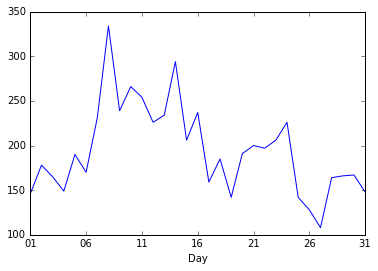

In [132]:
# Total closures (count) by day in minutes
df.groupby('Day').count()['Duration'].plot()

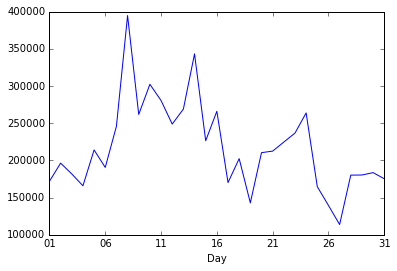

In [130]:
# Total closure time by day
(df.groupby('Day').sum()['Duration']/60).plot()


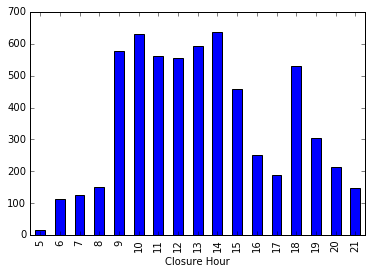

In [128]:
# Closures by time of day
df.groupby('Closure Hour').count()['Duration'].plot(kind='bar')

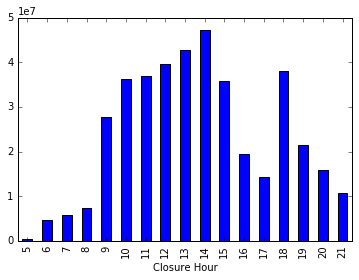

In [127]:
# Closures by time of day
df.groupby('Closure Hour').sum()['Duration'].plot(kind='bar')

In [39]:
# Looks there are some records with very long opening, perhaps errors?
# We can dig into that later, or just drop the really long records for now
df['Duration'].max()/3600

0

In [40]:
# Select closings less than 2 hours
# df = df[df['Duration'] < 3600*2]

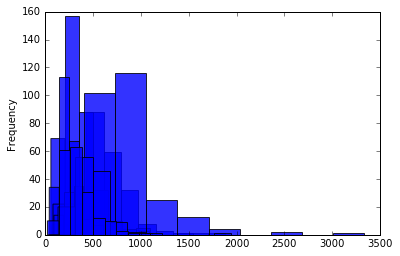

In [22]:
# Distribution by bridge
for bridge in df.groupby('Bridge').count().index:
    outdf = df[df['Bridge'] == bridge]
    outdf['Duration'].plot(kind='hist',subplots=True, alpha=0.8)
#     newdf['Duration'].hist(by=newdf.index,subplots=True, alpha=0.8)

In [41]:
len(df)

1574

In [42]:
df

,Duration,Closure Hour,Closure Minute,Closure Second,Bridge,Date,Year,Month,Day
0,1236,12,21,17,1st Ave S,2015-11-09,2015,11,09
1,544,13,12,34,1st Ave S,2015-11-09,2015,11,09
2,332,18,4,26,1st Ave S,2015-11-10,2015,11,10
3,513,18,12,57,1st Ave S,2015-11-10,2015,11,10
4,64,18,26,38,1st Ave S,2015-11-10,2015,11,10
5,481,19,5,15,1st Ave S,2015-11-10,2015,11,10
6,589,19,34,50,1st Ave S,2015-11-10,2015,11,10
7,291,19,46,43,1st Ave S,2015-11-10,2015,11,10
8,426,19,54,31,1st Ave S,2015-11-10,2015,11,10
9,543,20,5,26,1st Ave S,2015-11-10,2015,11,10
